# **MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿**

## **과제 4️⃣**
### 자유 주제
#### 영화 산업의 미래를 예측할 수 있는 새로운 관점에서 데이터를 분석하고, 영화 제작사나 투자자에게 유용한 인사이트를 자유롭게 제시하세요.

## **영화 키워드 분석을 통한 흥행 예측**

- 키워드 분석: TMDB의 줄거리(overview) 데이터에서 키워드를 추출하여 장르별, 흥행 성적별로 키워드 클라우드를 시각화.
    - 흥행에 성공한 영화들이 공통적으로 사용하는 키워드(예: '우주', '마법', '사랑', '복수' 등)를 찾아내고, 이를 통해 시나리오 기획 단계에 도움을 줄 수 있는 인사이트를 제시하기.

#### **기존 데이터 정제 파일에 키워드 데이터 추가로 수집 후 병합하여 저장**

In [2]:
import pandas as pd
import requests
import os

# .env 파일에서 환경 변수 불러오기 (dotenv 라이브러리가 필요할 수 있습니다)
# pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

# 환경 변수에서 TMDB API 키 가져오기
TMDB_API_KEY = os.getenv('TMDB_API_KEY')

# 기존 영화 데이터 불러오기
df = pd.read_csv('tmdb_kr_theatrical_clean.csv')

# 키워드 데이터를 저장할 빈 리스트 생성
all_keywords = []

# 각 영화 ID를 순회하며 API 호출
for movie_id in df['movie_id'].unique():
    if not TMDB_API_KEY:
        print("API 키가 설정되지 않았습니다. .env 파일에 TMDB_API_KEY를 설정했는지 확인하세요.")
        break
        
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/keywords?api_key={TMDB_API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        keywords_list = data.get('keywords', [])

        if keywords_list:
            # 키워드 정보를 딕셔너리로 저장
            for keyword in keywords_list:
                all_keywords.append({
                    'movie_id': movie_id,
                    'keyword_name': keyword['name']
                })

# 키워드 데이터프레임 생성
keywords_df = pd.DataFrame(all_keywords)

# 'movie_id'를 기준으로 기존 데이터프레임과 키워드 데이터프레임 병합
merged_df = pd.merge(df, keywords_df, on='movie_id', how='left')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
merged_df.to_csv('merged_movie_data.csv', index=False)

print("\n키워드 데이터 수집 및 병합이 완료되었습니다. 'merged_movie_data.csv' 파일이 생성되었습니다.")


키워드 데이터 수집 및 병합이 완료되었습니다. 'merged_movie_data.csv' 파일이 생성되었습니다.


#### **키워드 별 빈도수**

In [3]:
import pandas as pd
from collections import Counter
from IPython.display import display

# 병합된 데이터프레임 불러오기
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 이전 단계 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# NaN 값을 빈 문자열로 대체하여 오류 방지
merged_df['keyword_name'] = merged_df['keyword_name'].fillna('')

# 'movie_id'를 기준으로 그룹화하고 키워드들을 한 컬럼에 합치기
grouped_df = merged_df.groupby('movie_id')['keyword_name'].apply(lambda x: ', '.join(x)).reset_index()

# 모든 키워드를 하나의 리스트로 통합
all_keywords = []
for keywords_string in grouped_df['keyword_name']:
    keywords = keywords_string.split(', ')
    all_keywords.extend(keywords)

# 빈 문자열 제거
all_keywords = [keyword for keyword in all_keywords if keyword]

# 키워드 빈도수 계산
keyword_counts = Counter(all_keywords)

# 가장 자주 등장하는 상위 10개 키워드 추출
most_common_10 = keyword_counts.most_common(10)

# 결과를 데이터프레임으로 만들어 display
result_df = pd.DataFrame(most_common_10, columns=['Keyword', 'Count'])
display(result_df)

,Keyword,Count
0,south korea,31
1,seoul,8
2,revenge,7
3,disaster,7
4,based on true story,7
5,inter-korean relations,6
6,police,6
7,amused,5
8,busan,5
9,joseon dynasty (1392–1910),5


#### **revenue 기준 흥행 성공 영화 70개**

In [4]:
import pandas as pd
from IPython.display import display

# 데이터프레임 불러오기
df = pd.read_csv('tmdb_kr_theatrical_clean.csv')

# 수익, 예산, 런타임이 0보다 크고 투표수가 10 이상인 영화만 필터링
# df = df[(df['revenue'] > 0) & (df['budget'] > 0) & (df['vote_count'] >= 10) & (df['runtime'] > 0)]

# 수익(revenue) 기준으로 정렬 후 상위 30개 영화 추출하고 인덱스 초기화
top_revenue_movies = df.sort_values(by='revenue', ascending=False).head(70).reset_index(drop=True)

# 결과 확인
display(top_revenue_movies[['title', 'budget', 'revenue', 'vote_count', 'runtime']])

,title,budget,revenue,vote_count,runtime
0,기생충,11363000,257591776,19364,131
1,명량,9500000,138342258,300,128
2,신과함께-죄와 벌,18300000,125983972,1099,139
3,극한직업,8120000,124652206,316,111
4,넛잡: 땅콩 도둑들,42000000,120885527,1000,86
...,...,...,...,...,...
65,버닝,7280000,6591038,1692,148
66,탈출: 프로젝트 사일런스,14750000,6283415,352,96
67,만추,6200000,4820000,67,113
68,내 깡패 같은 애인,800000,4214668,15,105


##### **revenue 기준 상위 70개 영화 키워드 추가(keyword_name 컬럼이 null이면 제외)**

In [5]:
import pandas as pd
from IPython.display import display

# --- 1단계: 키워드 데이터가 포함된 파일 불러오기 ---
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 이전 단계 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# --- 2단계: 신뢰성 높은 데이터로 필터링 ---
filtered_df = merged_df[
    (merged_df['revenue'] > 0) & 
    (merged_df['budget'] > 0) & 
    (merged_df['runtime'] > 0) & 
    (merged_df['vote_count'] >= 10)
].copy()

# --- 3단계: 영화별로 키워드 합치기 ---
grouped_df = filtered_df.groupby('movie_id').agg({
    'title': 'first',
    'revenue': 'first',
    'budget': 'first',
    'runtime': 'first',
    'vote_count': 'first',
    'vote_average': 'first',
    'popularity': 'first',
    'keyword_name': lambda x: ', '.join(x.dropna().unique())
}).reset_index()

# **수정된 부분: 키워드가 없는 영화들 제외**
grouped_df = grouped_df[grouped_df['keyword_name'].str.strip() != ''].copy()

# --- 4단계: revenue 기준으로 상위 70개 영화 추출 및 결과 확인 ---
# 수익(revenue) 기준으로 내림차순 정렬 후 상위 70개 영화를 선택합니다.
top_70_revenue_movies = grouped_df.sort_values(by='revenue', ascending=False).head(70).reset_index(drop=True)

print("총수익 기준 상위 70개 흥행 영화:")
display(top_70_revenue_movies[['title', 'revenue', 'budget', 'popularity', 'vote_average', 'keyword_name']])

총수익 기준 상위 70개 흥행 영화:


,title,revenue,budget,popularity,vote_average,keyword_name
0,기생충,257591776,11363000,15.6336,8.498,"dark comedy, private lessons, birthday party, ..."
1,명량,138342258,9500000,1.9273,6.988,"navy, biography, based on true story, battlesh..."
2,신과함께-죄와 벌,125983972,18300000,5.4082,8.070,"afterlife, hell, trial, based on comic, god, g..."
3,극한직업,124652206,8120000,3.0460,7.144,"drug crime, police, ambush, detective, chicken..."
4,넛잡: 땅콩 도둑들,120885527,42000000,2.5080,5.857,"squirrel, villain, heist, anthropomorphism, pa..."
...,...,...,...,...,...,...
65,버닝,6591038,7280000,3.9276,7.382,"fire, jealousy, dreams, countryside, love tria..."
66,탈출: 프로젝트 사일런스,6283415,14750000,7.8078,7.000,"asia, bridge, disaster, dog, incheon"
67,만추,4820000,6200000,1.1179,6.910,"prisoner, seattle, washington, gigolo, vacatio..."
68,여고괴담 5: 동반자살,3470000,125000,2.2197,5.465,"suicide, supernatural, gore, high school student"


##### **revenue 기준 상위 70개 영화 키워드 빈도 분석 (키워드 'south korea' 제외)**

총수익 기준 상위 70개 흥행 영화의 키워드 빈도수 ('south korea' 제외):


,Keyword,Count
0,seoul,8
1,disaster,7
2,revenge,7
3,based on true story,6
4,police,6
5,joseon dynasty (1392–1910),5
6,amused,5
7,busan,5
8,based on comic,4
9,detective,4


C:\Users\sec\AppData\Local\Temp\ipykernel_115596\2742441832.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


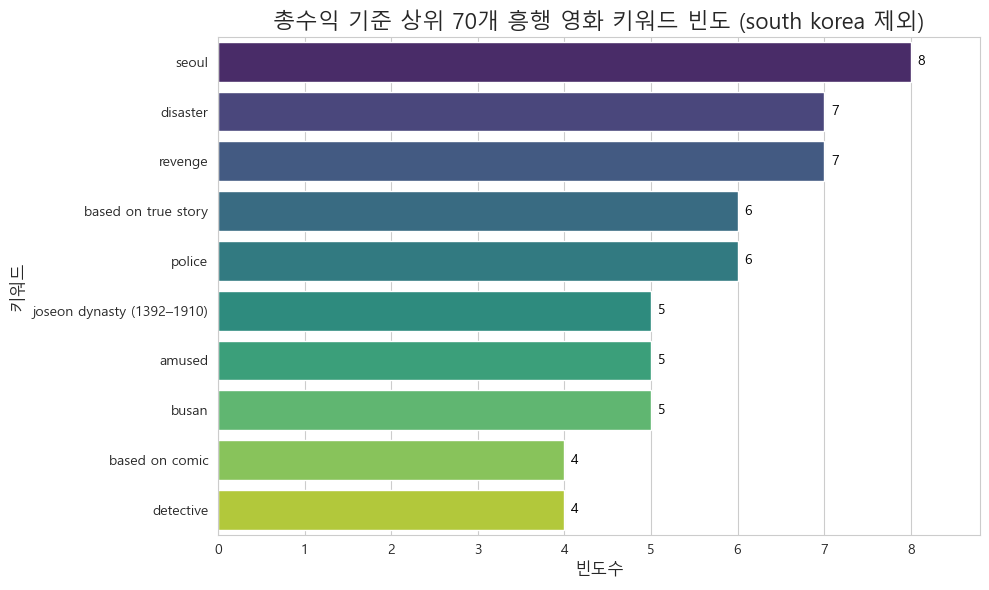

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# 불필요한 경고 메시지 무시 및 한글 폰트 설정
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

# --- 1단계: 키워드 데이터 파일 불러오기 및 필터링 ---
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 이전 단계 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# 신뢰성 높은 데이터로 필터링
filtered_df = merged_df[
    (merged_df['revenue'] > 0) & 
    (merged_df['budget'] > 0) & 
    (merged_df['runtime'] > 0) & 
    (merged_df['vote_count'] >= 10)
].copy()

# --- 2단계: 영화별 키워드 합치기 ---
# 영화 ID를 기준으로 데이터를 그룹화하고 키워드를 합칩니다.
grouped_df = filtered_df.groupby('movie_id').agg({
    'title': 'first',
    'revenue': 'first',
    'budget': 'first',
    'runtime': 'first',
    'vote_count': 'first',
    'keyword_name': lambda x: ', '.join(x.dropna().unique())
}).reset_index()

# 키워드가 없는 영화들 제외
grouped_df = grouped_df[grouped_df['keyword_name'].str.strip() != ''].copy()

# --- 3단계: 총수익 기준으로 상위 70개 영화 추출 ---
# 수익(revenue) 기준으로 내림차순 정렬 후 상위 70개 영화를 선택합니다.
top_70_revenue_movies = grouped_df.sort_values(by='revenue', ascending=False).head(70).reset_index(drop=True)

# --- 4단계: 키워드 빈도 분석 및 시각화 ---
# 영화별로 합쳐진 키워드를 다시 하나의 긴 리스트로 분리합니다.
all_keywords = []
for keywords_string in top_70_revenue_movies['keyword_name']:
    keywords = keywords_string.split(', ')
    all_keywords.extend(keywords)

# 'south korea' 키워드 제외
all_keywords = [keyword for keyword in all_keywords if keyword not in ['south korea']]

# 빈 문자열을 제거합니다.
all_keywords = [keyword for keyword in all_keywords if keyword]

# 키워드 빈도수 계산
keyword_counts = Counter(all_keywords)

# 가장 자주 등장하는 상위 10개 키워드를 데이터프레임으로 변환
keyword_df = pd.DataFrame(keyword_counts.most_common(10), columns=['Keyword', 'Count'])

# 결과를 출력합니다.
print("총수익 기준 상위 70개 흥행 영화의 키워드 빈도수 ('south korea' 제외):")
display(keyword_df)

# 막대 그래프로 시각화
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(10, 6))

# 막대 그래프 생성
ax = sns.barplot(
    x='Count',
    y='Keyword',
    data=keyword_df,
    palette='viridis',
    order=keyword_df['Keyword']
)

# 그래프 제목 및 축 레이블 설정
plt.title('총수익 기준 상위 70개 흥행 영화 키워드 빈도 (south korea 제외)', fontsize=16)
plt.xlabel('빈도수', fontsize=12)
plt.ylabel('키워드', fontsize=12)

# 그래프 범위 조정 및 x축 눈금을 정수로 설정
max_count = keyword_df['Count'].max()
plt.xlim(0, max_count * 1.1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 막대 옆에 빈도수 숫자 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black',
                xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()


#### **ROI 기준 흥행 성공 영화 70개**

In [7]:
import pandas as pd
from IPython.display import display

# 데이터프레임 불러오기
df = pd.read_csv('tmdb_kr_theatrical_clean.csv')

# 수익과 예산이 0보다 크고 투표수가 10 이상인 영화만 필터링
# df = df[(df['revenue'] > 0) & (df['budget'] > 0) & (df['vote_count'] >= 10)]

# ROI 컬럼 생성
df['roi'] = (df['revenue'] - df['budget']) / df['budget']

# ROI 기준으로 정렬 후 상위 70개 영화 추출하고 인덱스 초기화
top_roi_movies = df.sort_values(by='roi', ascending=False).head(70).reset_index(drop=True)

# 결과 확인
display(top_roi_movies[['title', 'budget', 'revenue', 'vote_count', 'roi']])

,title,budget,revenue,vote_count,roi
0,악녀,125000,8737458,723,68.899664
1,피에타,103000,6616296,389,63.235883
2,터널,1000000,52444295,610,51.444295
3,아저씨,1255000,43059790,1380,33.310590
4,여고괴담 5: 동반자살,125000,3470000,57,26.760000
...,...,...,...,...,...
65,버닝,7280000,6591038,1692,-0.094638
66,노량: 죽음의 바다,40000000,34210966,149,-0.144726
67,만추,6200000,4820000,67,-0.222581
68,하이파이브,14450000,10551515,21,-0.269791


##### **ROI 기준 상위 70개 영화 키워드 컬럼 추가**

In [8]:
import pandas as pd
from IPython.display import display

# --- 1단계: 키워드 데이터가 포함된 파일 불러오기 ---
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 키워드 API 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# --- 2단계: 신뢰성 높은 데이터로 필터링 및 ROI 계산 ---
filtered_df = merged_df[
    (merged_df['revenue'] > 0) & 
    (merged_df['budget'] > 0) & 
    (merged_df['runtime'] > 0) & 
    (merged_df['vote_count'] >= 10)
].copy()

# ROI 컬럼 생성
filtered_df['roi'] = (filtered_df['revenue'] - filtered_df['budget']) / filtered_df['budget']

# --- 3단계: 영화별로 키워드 합치기 ---
grouped_df = filtered_df.groupby('movie_id').agg({
    'title': 'first',
    'revenue': 'first',
    'budget': 'first',
    'runtime': 'first',
    'vote_count': 'first',
    'vote_average': 'first',
    'popularity': 'first',
    'roi': 'first',
    'keyword_name': lambda x: ', '.join(x.dropna().unique())
}).reset_index()

# --- 4단계: ROI 기준으로 상위 70개 영화 추출 및 결과 확인 ---
# ROI 기준으로 내림차순 정렬 후 상위 70개 영화를 선택합니다.
top_70_roi_movies = grouped_df.sort_values(by='roi', ascending=False).head(70).reset_index(drop=True)

print("ROI 기준 상위 70개 흥행 영화:")
display(top_70_roi_movies[['title', 'roi', 'revenue', 'budget', 'popularity', 'vote_average', 'keyword_name']])

ROI 기준 상위 70개 흥행 영화:


,title,roi,revenue,budget,popularity,vote_average,keyword_name
0,악녀,68.899664,8737458,125000,2.2810,6.909,"assassin, katana, revenge, hand to hand combat..."
1,피에타,63.235883,6616296,103000,1.2467,7.076,"revenge, attempted rape, incest, mature, long ..."
2,터널,51.444295,52444295,1000000,2.3042,7.305,"survival, disaster, reporter, trapped, rescue ..."
3,아저씨,33.310590,43059790,1255000,4.6157,7.699,"friendship, martial arts, assassin, hero, hitm..."
4,여고괴담 5: 동반자살,26.760000,3470000,125000,2.2197,5.465,"suicide, supernatural, gore, high school student"
...,...,...,...,...,...,...,...
65,버닝,-0.094638,6591038,7280000,3.9276,7.382,"fire, jealousy, dreams, countryside, love tria..."
66,노량: 죽음의 바다,-0.144726,34210966,40000000,2.6362,6.400,"japanese invasion of korea, joseon dynasty (13..."
67,만추,-0.222581,4820000,6200000,1.1179,6.910,"prisoner, seattle, washington, gigolo, vacatio..."
68,하이파이브,-0.269791,10551515,14450000,4.3287,7.095,"super power, organ transplant, superhero team"


##### **ROI 기준 상위 70개 영화 키워드('south korea' 제외) 빈도 분석**

ROI 기준 상위 70개 흥행 영화의 키워드 빈도수 ('south korea' 제외):


,Keyword,Count
0,seoul,8
1,revenge,7
2,disaster,6
3,police,6
4,based on true story,6
5,joseon dynasty (1392–1910),5
6,busan,5
7,detective,4
8,amused,4
9,zombie,4


C:\Users\sec\AppData\Local\Temp\ipykernel_115596\2286576846.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


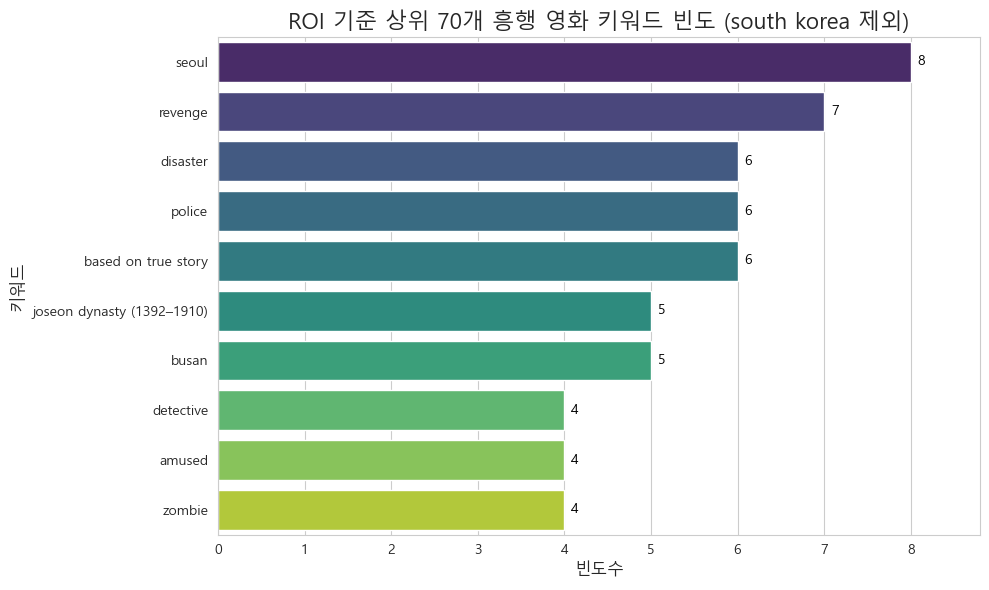

In [9]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
from matplotlib.ticker import MaxNLocator

# 불필요한 경고 메시지 무시 및 한글 폰트 설정
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

# --- 1단계: 데이터 불러오기 및 필터링 ---
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 이전 단계 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# 신뢰성 높은 데이터로 필터링
filtered_df = merged_df[
    (merged_df['revenue'] > 0) & 
    (merged_df['budget'] > 0) & 
    (merged_df['runtime'] > 0) & 
    (merged_df['vote_count'] >= 10)
].copy()

# --- 2단계: ROI 계산 및 영화별 키워드 합치기 ---
# ROI 컬럼을 생성합니다.
filtered_df['roi'] = (filtered_df['revenue'] - filtered_df['budget']) / filtered_df['budget']

# 영화 ID를 기준으로 데이터를 그룹화하고 키워드를 합칩니다.
grouped_df = filtered_df.groupby('movie_id').agg({
    'title': 'first',
    'roi': 'first',
    'keyword_name': lambda x: ', '.join(x.dropna().unique())
}).reset_index()

# 키워드가 없는 영화들 제외
grouped_df = grouped_df[grouped_df['keyword_name'].str.strip() != ''].copy()

# ROI 기준으로 상위 70개 영화를 선택합니다.
top_70_roi_movies = grouped_df.sort_values(by='roi', ascending=False).head(70).reset_index(drop=True)

# --- 3단계: 키워드 빈도 분석 및 데이터프레임 생성 ---
# 영화별로 합쳐진 키워드를 다시 하나의 긴 리스트로 분리합니다.
all_keywords = []
for keywords_string in top_70_roi_movies['keyword_name']:
    keywords = keywords_string.split(', ')
    all_keywords.extend(keywords)

# 'south korea' 키워드 제외
all_keywords = [keyword for keyword in all_keywords if keyword not in ['south korea']]

# 빈 문자열을 제거합니다.
all_keywords = [keyword for keyword in all_keywords if keyword]

# 키워드 빈도수 계산
keyword_counts = Counter(all_keywords)

# 가장 자주 등장하는 상위 10개 키워드를 데이터프레임으로 변환
keyword_df = pd.DataFrame(keyword_counts.most_common(10), columns=['Keyword', 'Count'])

# 결과를 표 형태로 출력
print("ROI 기준 상위 70개 흥행 영화의 키워드 빈도수 ('south korea' 제외):")
display(keyword_df)

# --- 4단계: 시각화 ---
# 그래프 스타일 및 크기 설정
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(10, 6))

# 막대 그래프 생성
ax = sns.barplot(
    x='Count',
    y='Keyword',
    data=keyword_df,
    palette='viridis',
    order=keyword_df['Keyword']
)

# 그래프 제목 및 축 레이블 설정
plt.title('ROI 기준 상위 70개 흥행 영화 키워드 빈도 (south korea 제외)', fontsize=16)
plt.xlabel('빈도수', fontsize=12)
plt.ylabel('키워드', fontsize=12)

# 그래프 범위 조정 및 x축 눈금을 정수로 설정
max_count = keyword_df['Count'].max()
plt.xlim(0, max_count * 1.1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 막대 옆에 빈도수 숫자 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black',
                xytext=(5, 0), textcoords='offset points')

# 그래프 출력
plt.tight_layout()
plt.show()


#### **평점 & 인기도 기준 상위 70개 영화 ((평점 정규화 + 인기도 정규화) / 2 = 종합점수)**

In [14]:
import pandas as pd
from IPython.display import display

# 데이터프레임 불러오기
df = pd.read_csv('tmdb_kr_theatrical_clean.csv')


# --- 1. 정규화 ---
# 평점(vote_average) 정규화
min_vote_avg = df['vote_average'].min()
max_vote_avg = df['vote_average'].max()
df['normalized_vote_average'] = (df['vote_average'] - min_vote_avg) / (max_vote_avg - min_vote_avg)

# 인기도(popularity) 정규화
min_pop = df['popularity'].min()
max_pop = df['popularity'].max()
df['normalized_popularity'] = (df['popularity'] - min_pop) / (max_pop - min_pop)

# --- 2. 종합 점수 생성 ---
df['combined_score'] = (df['normalized_vote_average'] + df['normalized_popularity']) / 2

# 종합 점수 기준으로 내림차순 정렬 후 상위 70개 영화 추출
top_movies = df.sort_values(by='combined_score', ascending=False).head(70).reset_index(drop=True)

# 결과 확인
display(top_movies[['title', 'combined_score', 'vote_average', 'popularity', 'revenue', 'budget']])

,title,combined_score,vote_average,popularity,revenue,budget
0,기생충,1.000000,8.498,15.6336,257591776,11363000
1,아가씨,0.913960,8.202,14.0548,38600000,8575000
2,악인전,0.877505,7.848,14.1994,25775371,6500000
3,부산행,0.876396,7.753,14.5036,87547518,8500000
4,올드보이,0.842215,8.252,11.6819,17500000,3000000
...,...,...,...,...,...,...
65,헨젤과 그레텔,0.329717,6.700,1.5263,2206625,4000000
66,내 깡패 같은 애인,0.325572,6.800,1.0436,4214668,800000
67,두번째 사랑,0.321996,6.600,1.6460,689473,3500000
68,해적: 도깨비 깃발,0.320995,6.500,1.9713,10247262,19597380


##### **평점 + 인기도 기준 상위 70개 영화 키워드 컬럼 추가**

In [11]:
import pandas as pd
from IPython.display import display

# --- 1단계: 키워드 데이터가 포함된 파일 불러오기 ---
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 키워드 API 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# --- 2단계: 신뢰성 높은 데이터로 필터링 및 종합 점수 계산 ---
filtered_df = merged_df[
    (merged_df['revenue'] > 0) & 
    (merged_df['budget'] > 0) & 
    (merged_df['runtime'] > 0) & 
    (merged_df['vote_count'] >= 10)
].copy()

# 평점(vote_average) 정규화
min_vote_avg = filtered_df['vote_average'].min()
max_vote_avg = filtered_df['vote_average'].max()
filtered_df['normalized_vote_average'] = (filtered_df['vote_average'] - min_vote_avg) / (max_vote_avg - min_vote_avg)

# 인기도(popularity) 정규화
min_pop = filtered_df['popularity'].min()
max_pop = filtered_df['popularity'].max()
filtered_df['normalized_popularity'] = (filtered_df['popularity'] - min_pop) / (max_pop - min_pop)

# 종합 점수 생성
filtered_df['combined_score'] = (filtered_df['normalized_vote_average'] + filtered_df['normalized_popularity']) / 2

# --- 3단계: 영화별로 키워드 합치기 ---
grouped_df = filtered_df.groupby('movie_id').agg({
    'title': 'first',
    'revenue': 'first',
    'budget': 'first',
    'runtime': 'first',
    'vote_count': 'first',
    'vote_average': 'first',
    'popularity': 'first',
    'combined_score': 'first',
    'keyword_name': lambda x: ', '.join(x.dropna().unique())
}).reset_index()

# --- 4단계: 종합 점수 기준으로 상위 30개 영화 추출 및 결과 확인 ---
# 종합 점수(combined_score) 기준으로 내림차순 정렬 후 상위 70개 영화를 선택합니다.
top_70_combined_movies = grouped_df.sort_values(by='combined_score', ascending=False).head(70).reset_index(drop=True)

print("종합 점수 기준 상위 70개 흥행 영화:")
display(top_70_combined_movies[['title', 'combined_score', 'revenue', 'budget', 'popularity', 'vote_average', 'keyword_name']])

종합 점수 기준 상위 70개 흥행 영화:


,title,combined_score,revenue,budget,popularity,vote_average,keyword_name
0,기생충,1.000000,257591776,11363000,15.6336,8.498,"dark comedy, private lessons, birthday party, ..."
1,아가씨,0.913960,38600000,8575000,14.0548,8.202,"jealousy, based on novel or book, library, pic..."
2,악인전,0.877505,25775371,6500000,14.1994,7.848,"police, gangster, based on true story, serial ..."
3,부산행,0.876396,87547518,8500000,14.5036,7.753,"zombie, train, survival horror, pandemic, host..."
4,올드보이,0.842215,17500000,3000000,11.6819,8.252,"daughter, rage and hate, hostility, transforma..."
...,...,...,...,...,...,...,...
65,헨젤과 그레텔,0.329717,2206625,4000000,1.5263,6.700,fairy tale
66,내 깡패 같은 애인,0.325572,4214668,800000,1.0436,6.800,
67,두번째 사랑,0.321996,689473,3500000,1.6460,6.600,"adultery, pregnancy, woman director"
68,해적: 도깨비 깃발,0.320995,10247262,19597380,1.9713,6.500,"treasure, sequel, joseon dynasty (1392–1910)"


##### **평점 + 인기도 기준 상위 70개 영화 키워드('south korea' 제외) 빈도 분석**

종합 점수 기준 상위 70개 흥행 영화의 키워드 빈도수 (south korea 제외):


,Keyword,Count
0,seoul,8
1,revenge,7
2,disaster,7
3,police,6
4,based on true story,6
5,inter-korean relations,6
6,japanese occupation of korea,5
7,joseon dynasty (1392–1910),5
8,amused,4
9,zombie,4


C:\Users\sec\AppData\Local\Temp\ipykernel_115596\338398840.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


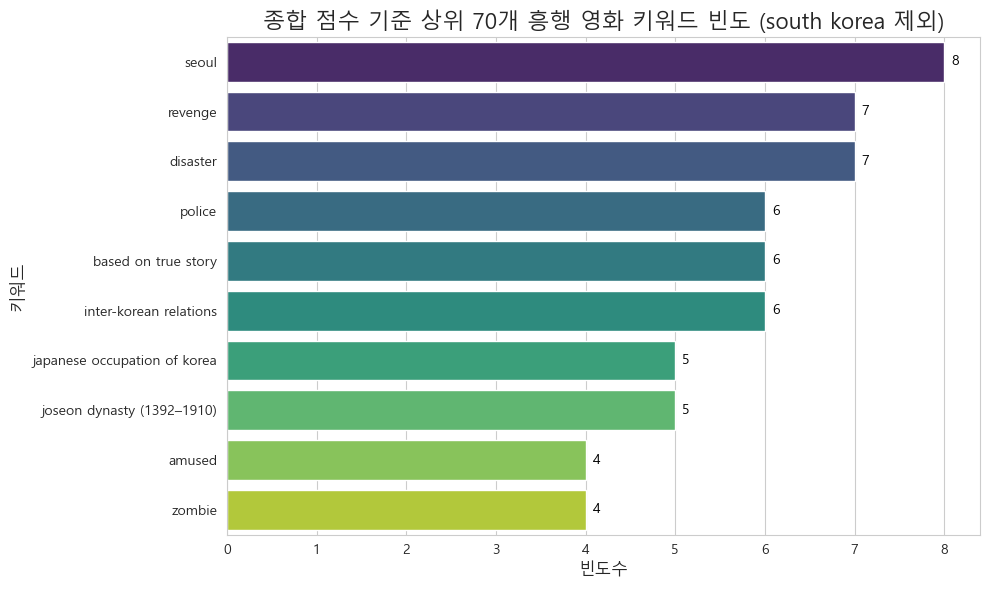

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from IPython.display import display


# 불필요한 경고 메시지 무시 및 한글 폰트 설정
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

# --- 1단계: 데이터 불러오기 및 필터링 ---
try:
    merged_df = pd.read_csv('merged_movie_data.csv')
except FileNotFoundError:
    print("오류: 'merged_movie_data.csv' 파일을 찾을 수 없습니다. 이전 단계 코드를 먼저 실행하여 파일을 생성해 주세요.")
    exit()

# 신뢰성 높은 데이터로 필터링합니다.
filtered_df = merged_df[
    (merged_df['revenue'] > 0) & 
    (filtered_df['budget'] > 0) & 
    (filtered_df['runtime'] > 0) & 
    (filtered_df['vote_count'] >= 10)
].copy()

# --- 2단계: 종합 점수 계산 및 영화별 키워드 합치기 ---
# 'popularity'와 'vote_average'를 정규화하여 종합 점수를 만듭니다.
filtered_df['normalized_popularity'] = (filtered_df['popularity'] - filtered_df['popularity'].min()) / (filtered_df['popularity'].max() - filtered_df['popularity'].min())
filtered_df['normalized_vote_average'] = (filtered_df['vote_average'] - filtered_df['vote_average'].min()) / (filtered_df['vote_average'].max() - filtered_df['vote_average'].min())
filtered_df['combined_score'] = filtered_df['normalized_popularity'] * 0.5 + filtered_df['normalized_vote_average'] * 0.5

# 영화 ID를 기준으로 데이터를 그룹화하고 키워드와 종합 점수를 합칩니다.
grouped_df = filtered_df.groupby('movie_id').agg({
    'title': 'first',
    'combined_score': 'first',
    'keyword_name': lambda x: ', '.join(x.dropna().unique())
}).reset_index()

# 종합 점수 기준으로 상위 70개 영화를 선택합니다.
top_70_combined_movies = grouped_df.sort_values(by='combined_score', ascending=False).head(70).reset_index(drop=True)

# --- 3단계: 키워드 빈도 분석 및 데이터프레임 생성 ---
# 영화별로 합쳐진 키워드를 다시 하나의 긴 리스트로 분리합니다.
all_keywords = []
for keywords_string in top_70_combined_movies['keyword_name']:
    keywords = keywords_string.split(', ')
    all_keywords.extend(keywords)

# 'south korea' 키워드 제외
all_keywords = [keyword for keyword in all_keywords if keyword not in ['south korea']]

# 빈 문자열을 제거합니다.
all_keywords = [keyword for keyword in all_keywords if keyword]

# 키워드 빈도수 계산
keyword_counts = Counter(all_keywords)

# 가장 자주 등장하는 상위 10개 키워드를 데이터프레임으로 변환
keyword_df = pd.DataFrame(keyword_counts.most_common(10), columns=['Keyword', 'Count'])

# 결과를 표 형태로 출력
print("종합 점수 기준 상위 70개 흥행 영화의 키워드 빈도수 (south korea 제외):")
display(keyword_df)

# --- 4단계: 시각화 ---
# 그래프 스타일 및 크기 설정
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(10, 6))

# 막대 그래프 생성
ax = sns.barplot(
    x='Count',
    y='Keyword',
    data=keyword_df,
    palette='viridis',
    order=keyword_df['Keyword']
)

# 그래프 제목 및 축 레이블 설정
plt.title('종합 점수 기준 상위 70개 흥행 영화 키워드 빈도 (south korea 제외)', fontsize=16)
plt.xlabel('빈도수', fontsize=12)
plt.ylabel('키워드', fontsize=12)

# 막대 옆에 빈도수 숫자 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black',
                xytext=(5, 0), textcoords='offset points')

# 그래프 출력
plt.tight_layout()
plt.show()
